# Wavegeometry model pre-process

Prepare the basic state in a zonally averaged atmosphere as input for the wavegeometry model by Nili Harnik and collegues. This envolves:

- open netCDF files for `uobs` & `tobs` with xarray and compute zonal mean
- read namelist to define model `grid`
- interpolate data from pressure to model coordinates
- compute `pv_gradient` and `buoancy_frequency`
- fill NaNs between upper limit of input date and model boundary

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client

In [2]:
%cd ../src
from basicstate import Grid, interp2z, buoancy_frequency, pv_gradient

/Users/wwicker/Desktop/wavegeometry_model/src


In [3]:
# Input filenames
u_files = ['../input/tu-eraint-37plevels-DJF-zonmean-bottom500-1979-2015.nc',]
t_files = ['../input/tu-eraint-37plevels-DJF-zonmean-bottom500-1979-2015.nc',]
namelist = '../input/nml-eraint'

outfile = '../input/era-int-basicstate.nc'

### Pre-process

In [4]:
client = Client()

# Derive zonal mean from netcdf files
# Use Numpy arrays
ds = xr.open_mfdataset(u_files,chunks={})
uobs = ds['u'].sel(lat=slice(90,0)).mean('lon')
uobs = np.flip(uobs.values,-1)

ds = xr.open_mfdataset(t_files,chunks={})
tobs = ds['t'].sel(lat=slice(90,0)).mean('lon')
tobs = np.flip(tobs.values,-1)

pressure = ds['lev'].values
lat = np.flip(ds.lat.sel(lat=slice(90,0)).values,-1)

client.close()

In [5]:
# read the namelist and define model grid
grid = Grid(namelist)

# interpolate u & t from pressure to z-coordinates with constant grid spacing
# this involves smoothing by convolution with 
u = interp2z(grid,uobs,pressure,nfilter=2)
t = interp2z(grid,tobs,pressure,nfilter=10)

In [6]:
# calculate squared buoancy frequency and pv gradient from in-situ temperature and zonal wind
N2 = buoancy_frequency(grid,t)
qy = pv_gradient(grid,u,N2)

In [7]:
# Fill NaNs in u, N2, and qy
def forward_fill(arr):
    '''
        found on stackoverflow
    '''
    df = pd.DataFrame(arr)
    df.fillna(method='ffill', axis=0, inplace=True)
    out = df.to_numpy()
    return out

for step in grid.t:
    u[step,:,:] = forward_fill(u[step,:,:])
    N2[step,:,:] = forward_fill(N2[step,:,:])
    qy[step,:,:] = forward_fill(qy[step,:,:])

### Plot basic state

Choose either time mean or random timestep

- interp2z fills out of bounds with np.nan
- each convolution extends the area with np.nan
- NaNs are filled for u, N2, and qy

In [8]:
# choose either time mean or random timestep
step = np.random.randint(0,len(grid.t))
#choose = lambda a: a[step,:,:]
choose = lambda a: a.mean(axis=0)

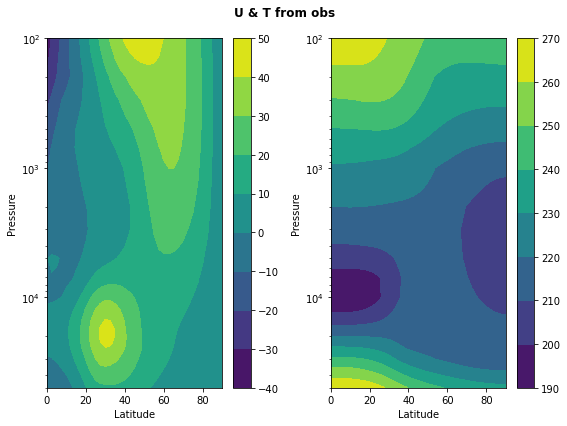

In [9]:
# plot U & T from obs
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(lat,pressure,choose(uobs))
axes[0].set_ylim(axes[0].get_ylim()[::-1])
axes[0].set_yscale('log')
axes[0].set_ylabel('Pressure')
axes[0].set_xlabel('Latitude')
plt.colorbar(Cs,ax=axes[0])
                   
Cs = axes[1].contourf(lat,pressure,choose(tobs))
axes[1].set_ylim(axes[1].get_ylim()[::-1])
axes[1].set_yscale('log')
axes[1].set_ylabel('Pressure')
axes[1].set_xlabel('Latitude')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T from obs',weight='bold')
fig.tight_layout()

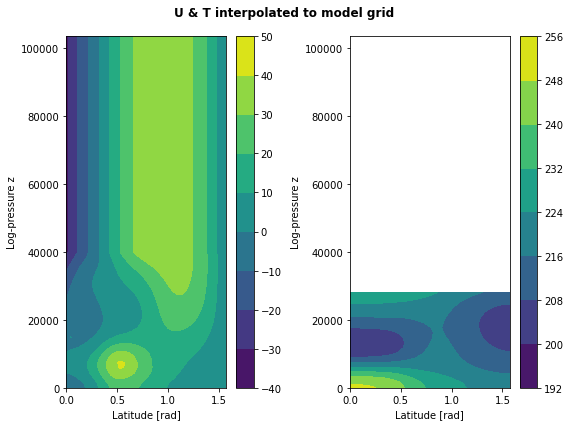

In [10]:
# plot U & T on model grid
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,choose(u))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,choose(t))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T interpolated to model grid',weight='bold')
fig.tight_layout()

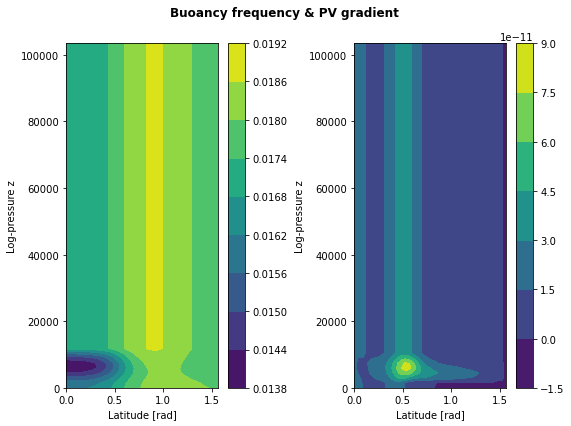

In [11]:
# plot buoancy frequency and pvgradient
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,np.sqrt(choose(N2)))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,choose(qy))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('Buoancy frequency & PV gradient',weight='bold')
fig.tight_layout()

### Store basic state to outfile